<a href="https://colab.research.google.com/github/Scox97/DS7331_Group_Project/blob/Lab1--EDA/DS7331_Group2_Phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS7331 Project: Phishing Dataset

- Hayoung Cheon
- Steven Cox
- Erika Dupond
- Miguel Zavala

### General Import

In [142]:
# general
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

# plots
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)


warnings.filterwarnings("ignore")

TABLE_LAYOUT = [
    {'selector': 'table', 'props': [('width', '100%')]},
    {'selector': 'thead th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left')]}
]

%matplotlib inline


In [143]:
# URL to the dataset
url = "https://archive.ics.uci.edu/static/public/967/phiusiil+phishing+url+dataset.zip"

# Read the CSV file from the URL, ignoring the first column (index 0)
df = pd.read_csv(url, encoding="utf-8")
df = df.drop("FILENAME", axis=1)  # Column "FILENAME" can be ignored.
print("\nShape of data:", df.shape)
df.head()



Shape of data: (235795, 55)


,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.00000,1.00000,0.52291,0.06193,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.00000,0.66667,0.03265,0.05021,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.00000,0.86667,0.02856,0.06413,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.00000,1.00000,0.52291,0.05761,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.00000,1.00000,0.07996,0.05944,...,1,0,1,244,15,34,72,1,85,1


In [144]:
df.describe()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
count,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,...,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000
mean,34.57310,21.47040,0.00271,78.43078,0.84551,0.26042,0.05575,2.76446,1.16476,0.00206,...,0.23701,0.02347,0.48677,26.07569,6.33311,10.52231,65.07111,2.37763,49.26252,0.57190
std,41.31415,9.15079,0.05195,28.97605,0.21663,0.25163,0.01059,0.59974,0.60097,0.04531,...,0.42525,0.15140,0.49983,79.41181,74.86630,22.31219,176.68754,17.64110,161.02743,0.49481
min,13.00000,4.00000,0.00000,0.15557,0.00000,0.00000,0.00108,2.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,23.00000,16.00000,0.00000,57.02479,0.68000,0.00598,0.05075,2.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
50%,27.00000,20.00000,0.00000,100.00000,1.00000,0.07996,0.05797,3.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,8.00000,2.00000,6.00000,12.00000,0.00000,10.00000,1.00000
75%,34.00000,24.00000,0.00000,100.00000,1.00000,0.52291,0.06288,3.00000,1.00000,0.00000,...,0.00000,0.00000,1.00000,29.00000,8.00000,15.00000,88.00000,1.00000,57.00000,1.00000
max,6097.00000,110.00000,1.00000,100.00000,1.00000,0.52291,0.09082,13.00000,10.00000,1.00000,...,1.00000,1.00000,1.00000,8956.00000,35820.00000,6957.00000,27397.00000,4887.00000,27516.00000,1.00000


### Check Imbalance

### Encoding High Cardinality Features

In [145]:
"""
# Optional Code: This is just to get the exercise going.

- Since URL and others high cardinality, can cause the model not to scale.
- In Addition, it is expensive computationally to produce such high cardinality features.
- There is an opportunity to do a Transformation to continuous attribute

Reference on: 
Julie Moeyersoms, David Martens
Including high-cardinality attributes in predictive models: A case study in churn prediction in the energy sector, Decision Support Systems, Volume 72,2015
Pages 72-81,
ISSN 0167-9236
https://www.sciencedirect.com/science/article/pii/S0167923615000275#s0120

Hash Encoding:  https://towardsdatascience.com/4-ways-to-encode-categorical-features-with-high-cardinality-1bc6d8fd7b13/
"""


def shannon_entropy(text):
    if not text or not isinstance(text, str):
        return 0
    counts = Counter(text)
    probs = [freq / len(text) for freq in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)


def pre_process_data(
    input_df, drop_cols=[], use_entropy=True, include_aggregates=False
):
    df = input_df.copy()
    y = df["label"]

    X = df.drop(columns=[col for col in drop_cols if col in df.columns] + ["label"])

    binary_cols = X.nunique() == 2
    for col in X.columns[binary_cols]:
        X[col] = X[col].astype(int)

    categorical_cols = X.select_dtypes(include=["object"]).columns
    low_cardinality_cols = [col for col in categorical_cols if X[col].nunique() < 200]
    high_cardinality_cols = [col for col in categorical_cols if X[col].nunique() >= 200]

    if use_entropy:
        for col in ["URL", "Domain", "Title"]:
            if col in df.columns:
                X[f"{col}_entropy"] = df[col].astype(str).apply(shannon_entropy)
                print(f"Entropy for {col}: {X[f'{col}_entropy'].mean():.4f}")

        X = X.drop(
            columns=[col for col in high_cardinality_cols if col in X.columns],
            errors="ignore",
        )
    else:
        hashed_dfs = []
        for col in high_cardinality_cols:
            unique_count = X[col].nunique()
            n_features = (
                10 if unique_count < 200 else min(max(unique_count // 10, 10), 500)
            )
            print(
                f"Hashing {col} with {n_features} features (from {unique_count} unique values)"
            )
            hasher = FeatureHasher(n_features=n_features, input_type="string")
            hashed_features = hasher.fit_transform(
                X[col].astype(str).values.reshape(-1, 1)
            )
            hashed_df = pd.DataFrame(
                hashed_features.toarray(),
                columns=[f"{col}_hash_{i}" for i in range(n_features)],
            )
            hashed_dfs.append(hashed_df)
            X = X.drop(columns=[col])
        if hashed_dfs:
            hashed_combined = pd.concat(hashed_dfs, axis=1).reset_index(drop=True)
            X = pd.concat([X.reset_index(drop=True), hashed_combined], axis=1)

    for col in low_cardinality_cols:
        dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
        X = pd.concat([X.drop(columns=[col]), dummies], axis=1)
        print(f"Dummy encoding {col} with {dummies.shape[1]} features")

    if include_aggregates:
        special_cols = [
            "NoOfEqualsInURL",
            "NoOfQMarkInURL",
            "NoOfAmpersandInURL",
            "NoOfOtherSpecialCharsInURL",
        ]
        resource_cols = ["NoOfImage", "NoOfCSS", "NoOfJS", "NoOfExternalRef"]
        if all(col in df.columns for col in special_cols):
            X["TotalSpecialChars"] = df[special_cols].sum(axis=1)
            print("Added TotalSpecialChars")
        if all(col in df.columns for col in resource_cols):
            X["TotalExternalResources"] = df[resource_cols].sum(axis=1)
            print("Added TotalExternalResources")

    return X, y


def check_leakage(df, columns=["URL", "Title"]):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    leakages = []
    for i, col in enumerate(columns):
        if col in df.columns:
            unique_vals = df.groupby(col)["label"].nunique()
            leaks = (unique_vals == 1).sum()
            total = len(unique_vals)
            leak_pct = leaks / total

        leakages.append(
            {
                "feature": col,
                "total": total,
                "leaks": leaks,
                "leak_pct": float(leak_pct * 100),
            }
        )

        categories = ["Leakage", "No Leakage"]
        values = [leaks, total - leaks]

        bars = axes[i].bar(categories, values)
        axes[i].set_title(f"Data Leakage in {col} Column")
        axes[i].set_ylabel("Count of Unique Values")

        for bar in bars:
            height = bar.get_height()
            axes[i].annotate(
                f"{height}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    plt.tight_layout()
    plt.show()

    leakages = pd.DataFrame(leakages)
    display(leakages)


def pca_analysis(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    pca = PCA().fit(X_scaled)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA: Explained Variance")
    plt.grid(True)
    plt.show()

#### PCA Analysis and Scaling

Hashing URL with 500 features (from 235370 unique values)
Hashing Domain with 500 features (from 220086 unique values)
Hashing TLD with 69 features (from 695 unique values)
Hashing Title with 500 features (from 197874 unique values)


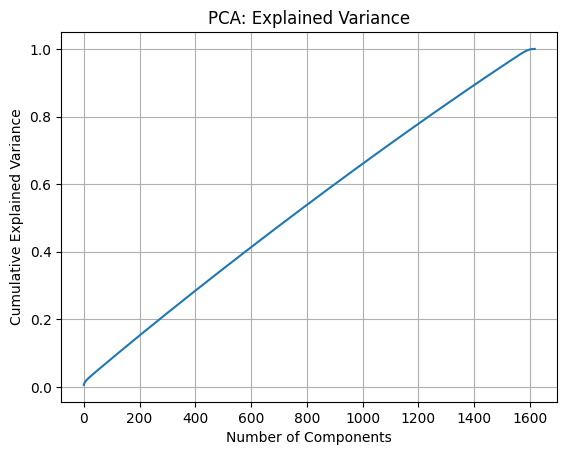

In [146]:
# PCA Check on preprocessed data
X, y = pre_process_data(df, use_entropy=False)
pca_analysis(X)

##### PCA Summary - Feature Space

The feature space has 1619 features (original + hashed)

###### Explained Variance Distribution

- The cumulative explained variance curve increases linearly with the number of components.
- About 1200 components are needed to explain ~80% of the total variance.
- The first few components do not capture a dominant share of variance, suggesting:
    - Our data is high-dimensional, with variance spread out across many features.
    - Little redundancy is apparent; most features contribute independently to variance.

###### Implications

- Dimensionality reduction (PCA) won’t significantly condense information into a small number of components.
- The hashing of high-cardinality features (e.g., URL, Title) spreads variance across many features, as each hashed bucket captures partial variance.

In [147]:
# Logistic Regression with Lasso with Hashed and Dummy encoded data - Warning this will take a while
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y, test_size=0.3, stratify=y, random_state=42
# )

# lasso = LogisticRegression(
#     C=0.05,
#     verbose=2,
#     l1_ratio=0.5,
#     max_iter=250,
#     solver="saga",
#     penalty="elasticnet",
# )

# lasso.fit(X_train, y_train)
# y_pred_proba = lasso.predict_proba(X_test)[:, 1]
# auc_lasso = roc_auc_score(y_test, y_pred_proba)
# print(f"Logistic Regression AUC: {auc_lasso:.3f}")

##### Leakages summary


- Initial Findings
  - Engineered hashed features from `URL` and `Title`, those categorical features initially displayed significant signals (domain knowledge).

- Discovery of Data Leakage
  - Analysis showed:
    - 100% of `URL`s correspond to a unique label – direct leakage.
    - 99.9% of `Title`s correspond to a unique label.
  - Hashing did not prevent leakage, as uniqueness was preserved in the hash.

- Dimensionality & Redundancy Check
  - PCA revealed:
    - ~80% variance explained by ~1200 components of ~1600 total features.

- Logistic Regression Modeling
  - Trained models with scikit-learn and PyTorch (LASSO).
  - Observed AUC=1.0 – clear overfitting due to leakage from raw `URL` and `Title`.

- Key Decision: Feature Dropping
  - Dropped `URL`, `Title`, and their hashed versions to eliminate data leakage.
  - Retained engineered features (e.g., `URLLength`, `ObfuscationRatio`, `LetterRatioInURL`).
- Recognized Logistic Regression’s limitations for high-dimensional, correlated data.

- Learning & Next Steps
  - Valuable lesson on how high-cardinality features can introduce leakage.
  - What to do next:
    - Focus on regularization, cross-validation, and robust validation strategies.


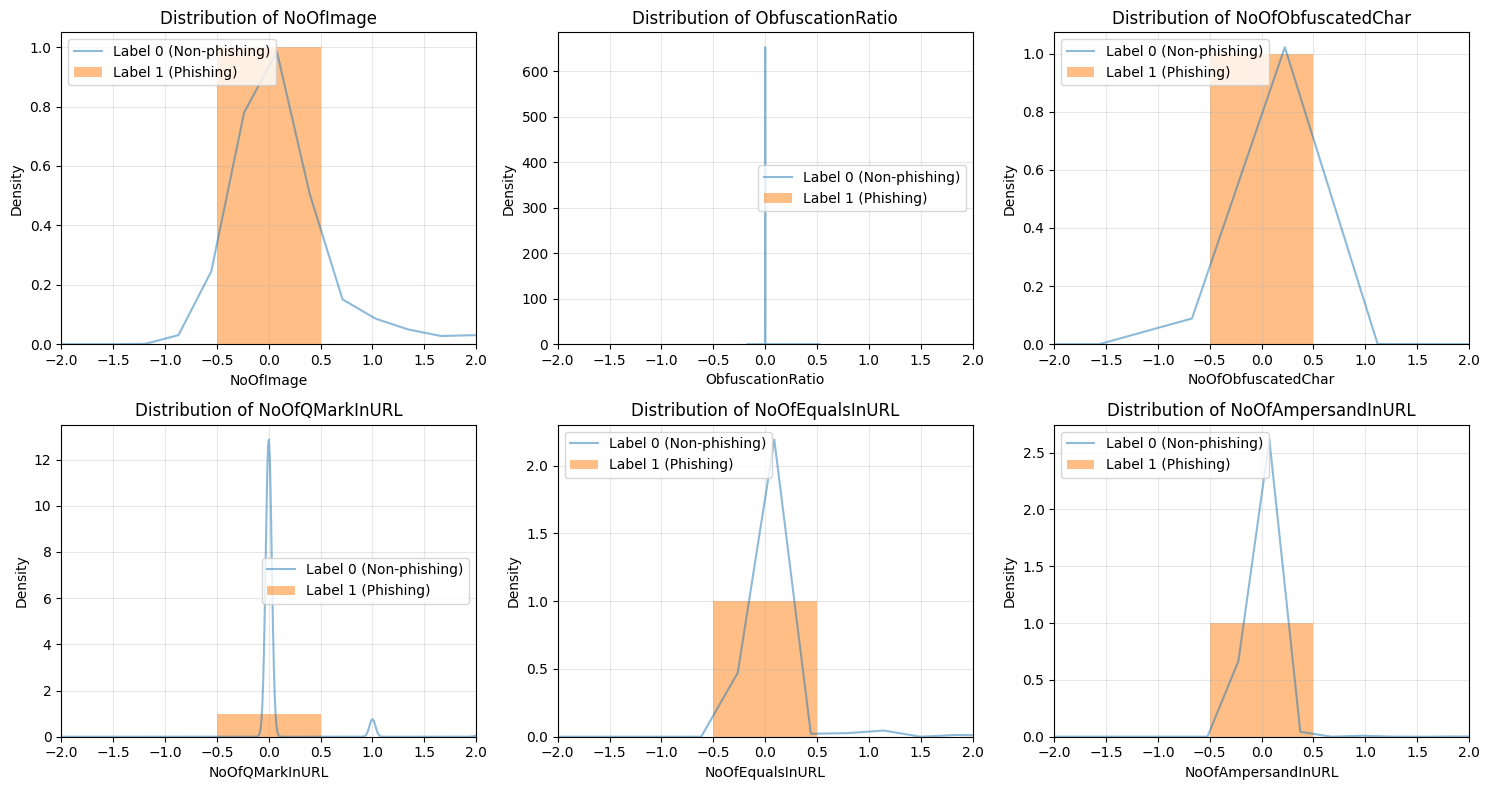

,NoOfImage,ObfuscationRatio,NoOfObfuscatedChar,NoOfQMarkInURL,NoOfEqualsInURL,NoOfAmpersandInURL
count,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000,235795.00000
mean,26.07569,0.00014,0.02486,0.02940,0.06224,0.02506
std,79.41181,0.00382,1.87625,0.19351,0.93470,0.83645
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,29.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,8956.00000,0.34800,447.00000,4.00000,176.00000,149.00000


In [148]:
def plot_relation_dist(ax, df, feature):
    data_0 = df[df['label'] == 0][feature]
    data_1 = df[df['label'] == 1][feature]

    if data_0.std() > 0:
        data_0.plot(kind='kde', ax=ax, label='Label 0 (Non-phishing)', alpha=0.5)

    ax.hist(data_1, bins=1, range=(-0.5,0.5), density=True, alpha=0.5, label='Label 1 (Phishing)')

    ax.set_xlim(-2, 2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(alpha=0.3)
    ax.legend()

potential_drop = [
    "NoOfImage",
    "ObfuscationRatio",
    "NoOfObfuscatedChar",
    "NoOfQMarkInURL",
    "NoOfEqualsInURL",
    "NoOfAmpersandInURL",
]

n_features = len(potential_drop)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(some_features):
    plot_relation_dist(axes[i], df, feature)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

df[potential_drop].describe()

Noticed these features were not that useful; starting with stats analysis, the low mean and standard deviation (close to 0) raised suspicions. Visualizations confirmed these features could act as shortcuts for class separation, especially in Logistic Regression, leading to overfitting and poor generalization.

### Modeling Logistic Regression

NoOfCSS                      464.40403
NoOfJS                       140.43576
NoOfEmptyRef                 106.82622
NoOfiFrame                    97.67735
NoOfDegitsInURL               94.87757
NoOfPopup                     84.95269
NoOfExternalRef               65.90025
NoOfSelfRef                   60.38138
NoOfLettersInURL              58.40258
URLLength                     53.32174
LineOfCode                    53.07230
LargestLineLength             48.17993
NoOfOtherSpecialCharsInURL    47.42852
DegitRatioInURL                3.24452
DomainLength                   2.51340
NoOfSubDomain                  1.80940
TLDLength                      1.66352
SpacialCharRatioInURL          1.18413
TLDLegitimateProb              0.07309
DomainTitleMatchScore         -0.00873
LetterRatioInURL              -0.06636
URLTitleMatchScore            -0.08908
URLCharProb                   -1.06429
CharContinuationRate          -1.12859
dtype: float64

URLCharProb             0.01059
SpacialCharRatioInURL   0.03239
DegitRatioInURL         0.07090
dtype: float64

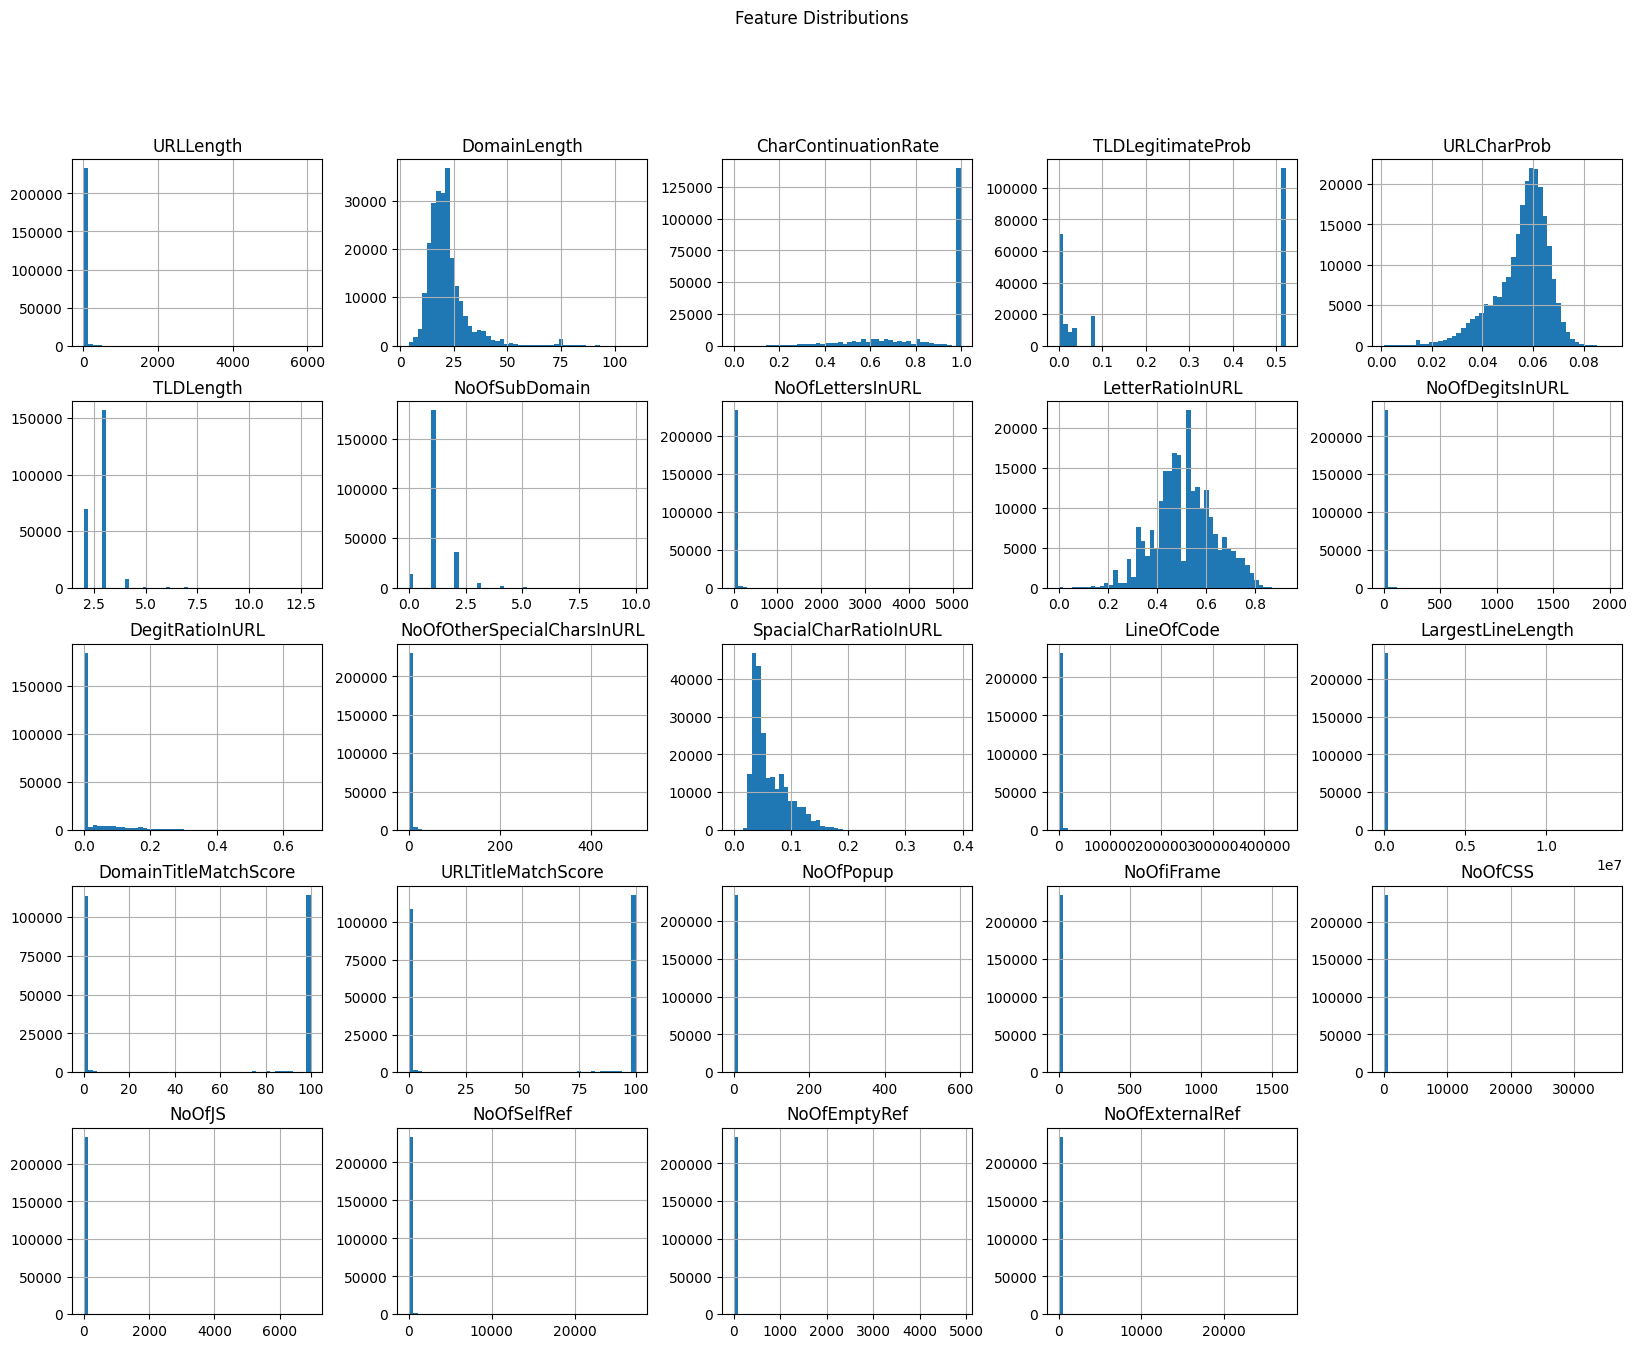

In [149]:
base_drop = [
    "URL",
    "Domain",
    "Title",
    "TLD",
    "URLSimilarityIndex",
    "HasSocialNet",
    "HasCopyrightInfo",
    "HasTitle",
    "IsHTTPS",
    "IsResponsive",
    "IsDomainIP",
    "HasDescription",
    "HasObfuscation",
    "HasSubmitButton",
    "HasExternalSubmitForm",
]
potential_drop = [
    "NoOfImage",
    "ObfuscationRatio",
    "NoOfObfuscatedChar",
    "NoOfQMarkInURL",
    "NoOfEqualsInURL",
    "NoOfAmpersandInURL",
]
drop = base_drop + potential_drop

X_final, y_final = pre_process_data(
    df, drop_cols=drop, use_entropy=False, include_aggregates=False
)

skewness = X_final[continuous_features].skew().sort_values(ascending=False)
display(skewness)


low_variance = X_final[continuous_features].std().sort_values()
display(low_variance[low_variance < 0.1])


X_final[continuous_features].hist(bins=50, figsize=(20,15))
plt.suptitle("Feature Distributions")
plt.show()


In [150]:
# Feature selection
continuous_features = [col for col in X_final.columns if X_final[col].nunique() > 2]

high_skew_features = [
    "NoOfCSS",
    "NoOfJS",
    "NoOfEmptyRef",
    "NoOfiFrame",
    "NoOfDegitsInURL",
    "NoOfPopup",
    "NoOfExternalRef",
    "NoOfSelfRef",
    "NoOfLettersInURL",
    "URLLength",
    "LineOfCode",
    "LargestLineLength",
    "NoOfOtherSpecialCharsInURL",
    "DegitRatioInURL",
    "DomainLength",
    "NoOfSubDomain",
    "TLDLength",
    "SpacialCharRatioInURL",
]
standard_scale_features = [
    col for col in continuous_features if col not in high_skew_features
]

preprocessor = ColumnTransformer(
    transformers=[
        ("log", FunctionTransformer(np.log1p, validate=True), high_skew_features),
        ("scale", StandardScaler(), standard_scale_features),
    ],
    remainder="passthrough",
)

lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.0001,
    max_iter=5000,
    n_jobs=-1,
    random_state=42,
)

pipeline = Pipeline([("preprocessor", preprocessor), ("lasso", lasso)])

print("\nRunning hold-out set evaluation...")
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X_final, y_final, test_size=0.3, random_state=42, stratify=y_final
)

pipeline.fit(X_train, y_train)
y_pred_proba = pipeline.predict_proba(X_holdout)[:, 1]
y_pred = pipeline.predict(X_holdout)

holdout_auc = roc_auc_score(y_holdout, y_pred_proba)
holdout_acc = accuracy_score(y_holdout, y_pred)
holdout_f1 = f1_score(y_holdout, y_pred)

print(f"\nHold-out AUC: {holdout_auc:.3f}")
print(f"Hold-out Accuracy: {holdout_acc:.3f}")
print(f"Hold-out F1 Score: {holdout_f1:.3f}")


Running hold-out set evaluation...

Hold-out AUC: 0.998
Hold-out Accuracy: 0.979
Hold-out F1 Score: 0.981


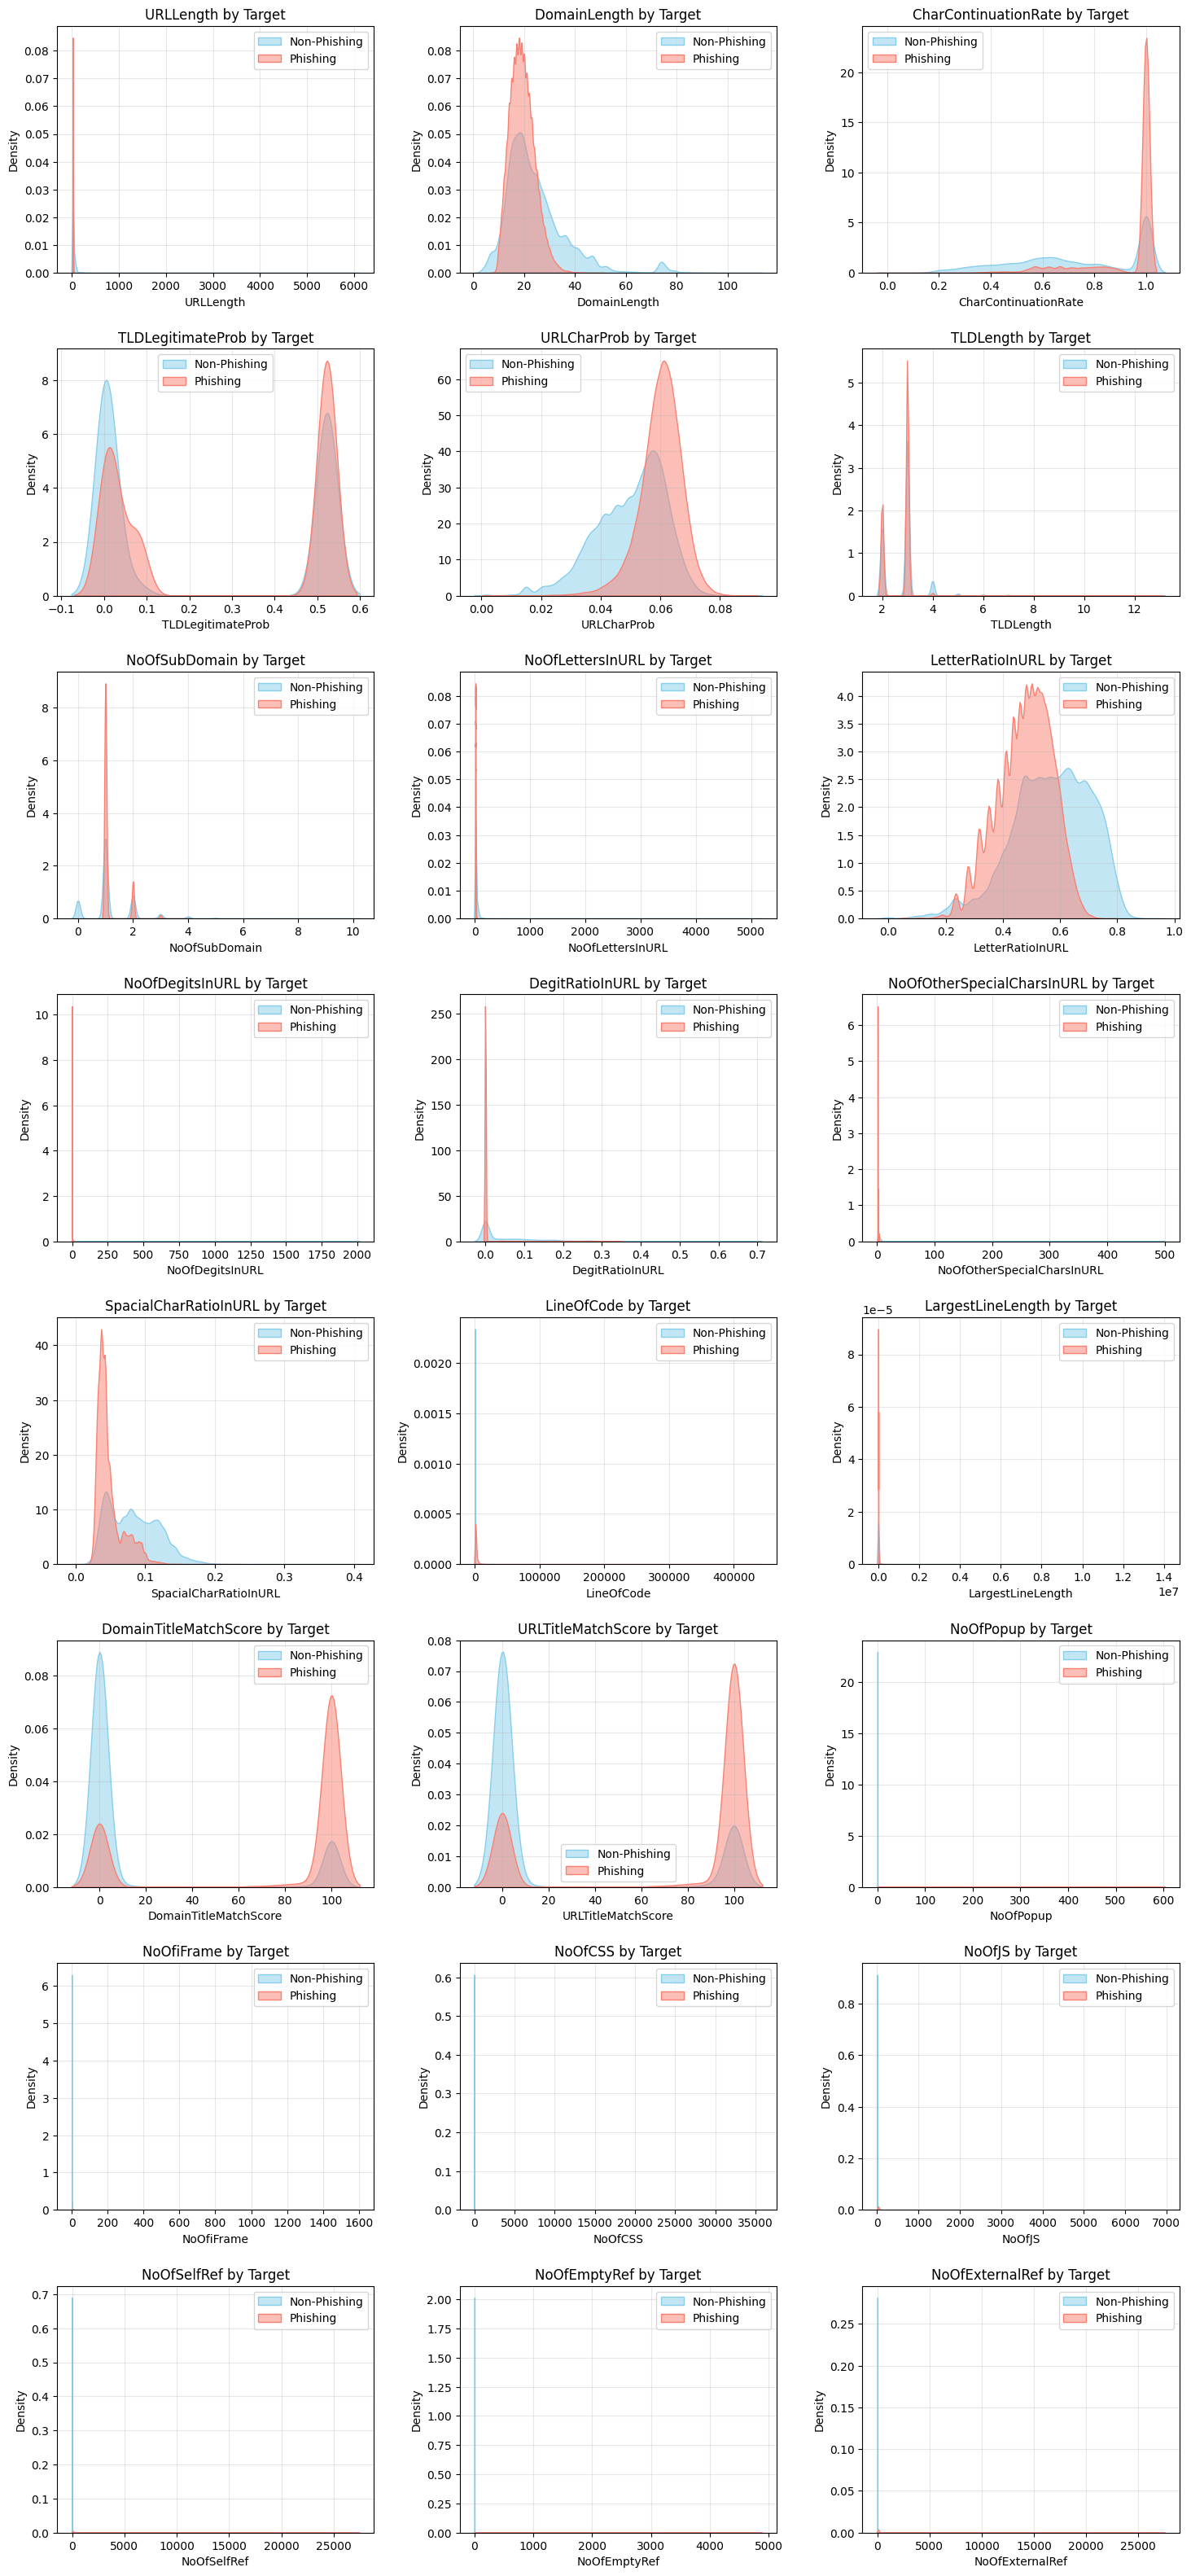


Correlations with Target:



,Pearson,Spearman
DomainTitleMatchScore,0.58490,0.56976
URLTitleMatchScore,0.53942,0.52515
SpacialCharRatioInURL,-0.53354,-0.52742
HasHiddenFields,0.50773,0.50773
HasFavicon,0.49371,0.49371
URLCharProb,0.46975,0.45911
CharContinuationRate,0.46774,0.47001
DegitRatioInURL,-0.43203,-0.53627
Robots,0.39262,0.39262
NoOfJS,0.37350,0.82301


In [151]:
numerical_cols = [
    col for col in X_final.select_dtypes(include=['float64', 'int64'])
    if X_final[col].nunique() > 2
]

num_cols = 3
num_rows = int(np.ceil(len(numerical_cols) / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))
axes = axes.flatten()

y_aligned = y_final.reset_index(drop=True)
X_aligned = X_final.reset_index(drop=True)

for i, feature in enumerate(numerical_cols):
    ax = axes[i]
    data_non_phishing = X_aligned[feature][y_aligned == 0].dropna()
    data_phishing = X_aligned[feature][y_aligned == 1].dropna()
    
    if data_non_phishing.nunique() > 1:
        sns.kdeplot(data_non_phishing, fill=True, color='skyblue', label='Non-Phishing', alpha=0.5, ax=ax)
    if data_phishing.nunique() > 1:
        sns.kdeplot(data_phishing, fill=True, color='salmon', label='Phishing', alpha=0.5, ax=ax)
    
    ax.set_title(f"{feature} by Target")
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
plt.show()


df_temp = X_final.copy()
df_temp['label'] = y_final
corr_pearson = df_temp.corr(method='pearson')['label'].sort_values(ascending=False)
corr_spearman = df_temp.corr(method='spearman')['label'].sort_values(ascending=False)

corr_df = pd.DataFrame({'Pearson': corr_pearson, 'Spearman': corr_spearman}).drop(index='label')
print("\nCorrelations with Target:\n")
display(corr_df.sort_values(by='Pearson', key=abs, ascending=False))


In [152]:

train_hashes = pd.util.hash_pandas_object(pd.DataFrame(X_train)).values
holdout_hashes = pd.util.hash_pandas_object(pd.DataFrame(X_holdout)).values
overlap = np.intersect1d(train_hashes, holdout_hashes)
print(f"Number of overlapping samples: {len(overlap)}")

y_pred = pipeline.predict(X_holdout)
cm = confusion_matrix(y_holdout, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_holdout, y_pred)
precision = precision_score(y_holdout, y_pred, zero_division=0)
recall = recall_score(y_holdout, y_pred, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
f1 = f1_score(y_holdout, y_pred, zero_division=0)

metrics_df = pd.DataFrame({
    "Metric": [
        "Accuracy",
        "Precision (PPV)",
        "Recall (Sensitivity)",
        "Specificity (TNR)",
        "Negative Predictive Value (NPV)",
        "F1 Score",
    ],
    "Value": [accuracy, precision, recall, specificity, npv, f1],
})

metrics_df["Value"] = (metrics_df["Value"] * 100).round(2).astype(str) + "%"
display(metrics_df)

conf_matrix_df = pd.DataFrame(
    cm,
    index=["Actual 0 (Non-phishing)", "Actual 1 (Phishing)"],
    columns=["Predicted 0 (Non-phishing)", "Predicted 1 (Phishing)"]
)
display(conf_matrix_df)

Number of overlapping samples: 0


,Metric,Value
0,Accuracy,97.88%
1,Precision (PPV),98.99%
2,Recall (Sensitivity),97.28%
3,Specificity (TNR),98.67%
4,Negative Predictive Value (NPV),96.45%
5,F1 Score,98.13%


,Predicted 0 (Non-phishing),Predicted 1 (Phishing)
Actual 0 (Non-phishing),29881,403
Actual 1 (Phishing),1099,39356


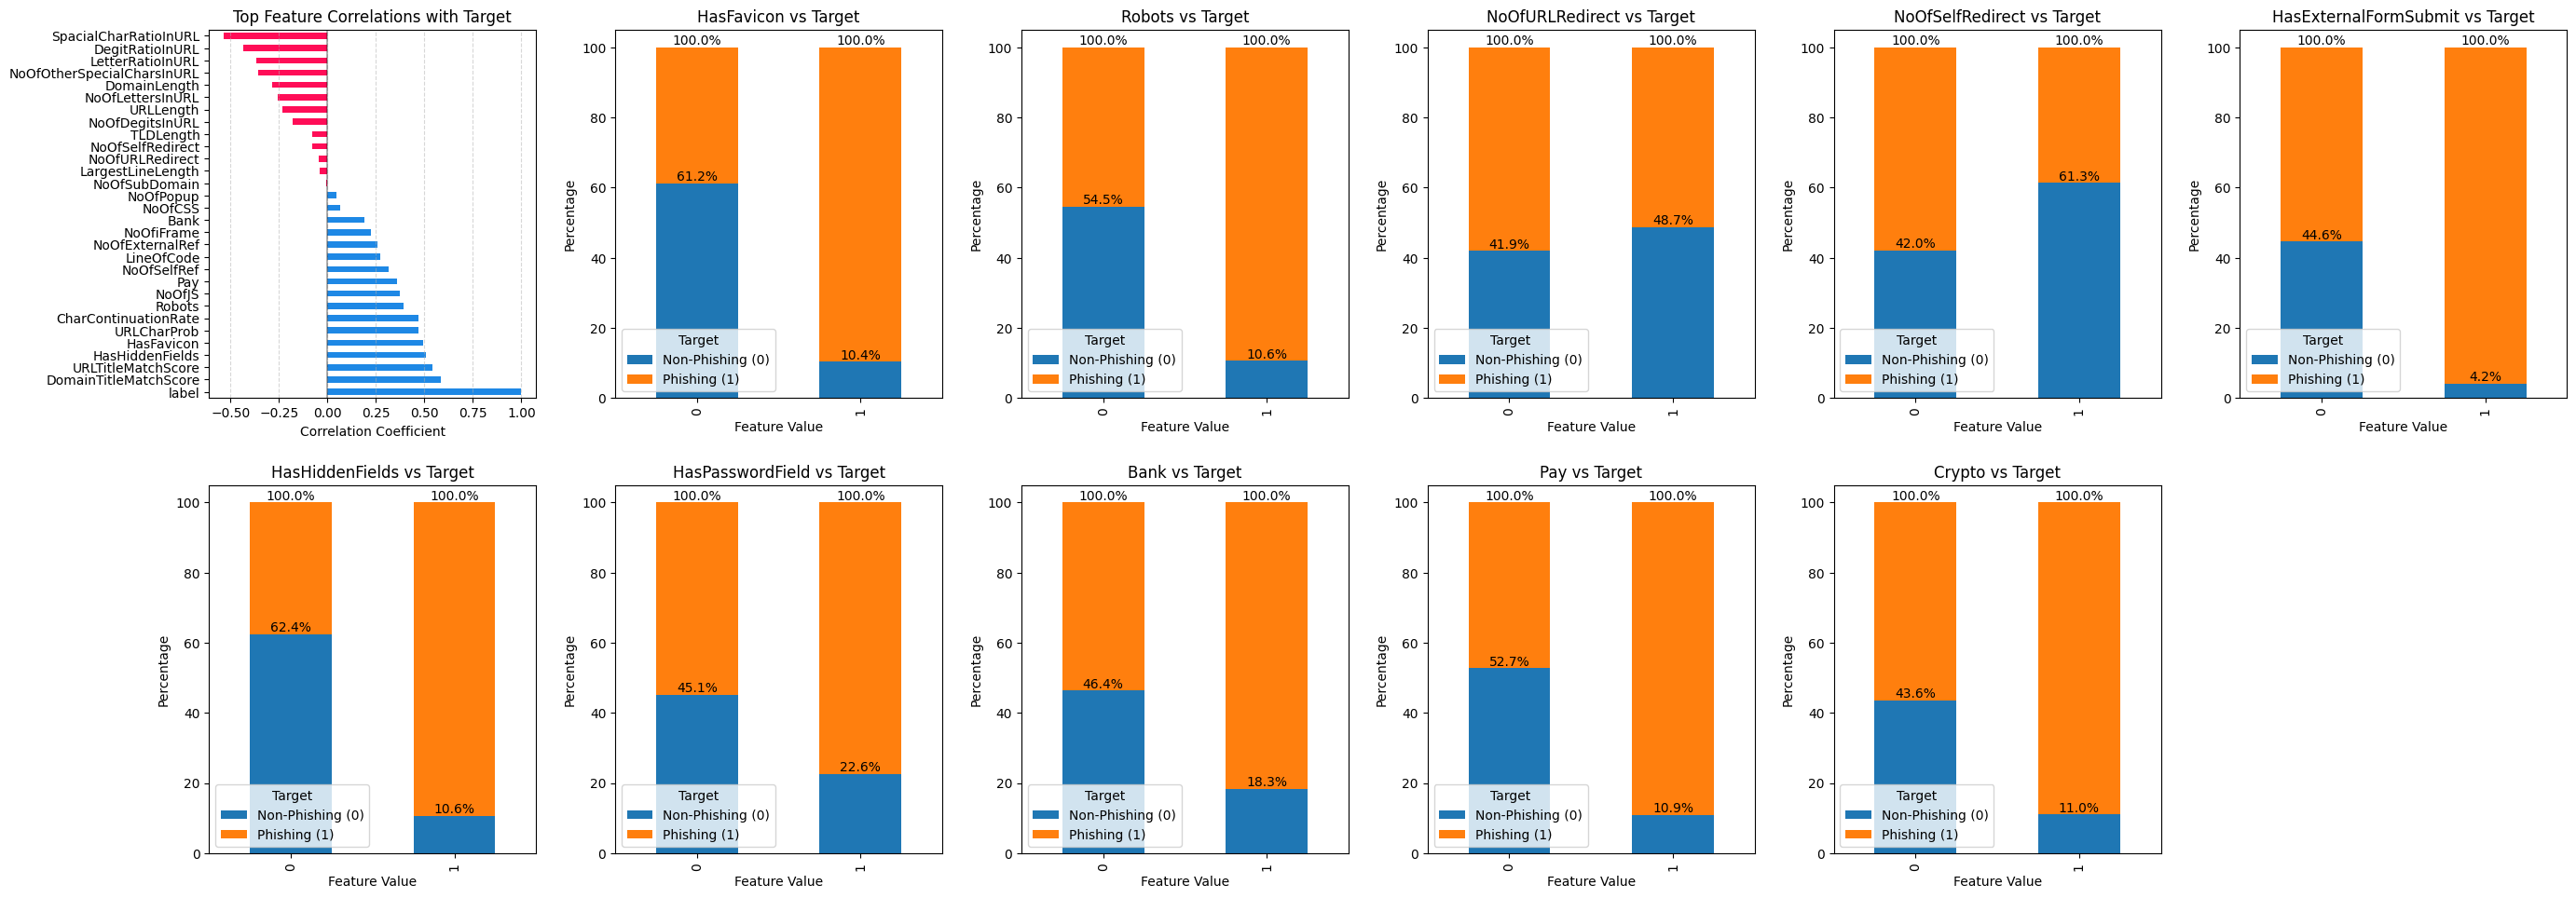

In [153]:
feature_correlations = X_final.copy()
feature_correlations["label"] = y_final
corrs = feature_correlations.corr()["label"].sort_values(ascending=False)

binary_features = []
for col in X_final.columns:
    unique_vals = X_final[col].nunique()
    if unique_vals == 2:
        binary_features.append(col)

num_cols = 6
total_plots = 1 + len(binary_features)
num_rows = math.ceil(total_plots / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(28, 5 * num_rows))
axes = axes.flatten()

top_n = 15
top_corrs = corrs.iloc[:top_n]
bottom_corrs = corrs.iloc[-top_n:] if len(corrs) > top_n else pd.Series()
plot_corrs = pd.concat([top_corrs, bottom_corrs])
colors = ["#1e88e5" if c > 0 else "#ff0d57" for c in plot_corrs]

ax0 = axes[0]
plot_corrs.plot(kind="barh", ax=ax0, color=colors)
ax0.set_title("Top Feature Correlations with Target", fontsize=12)
ax0.axvline(x=0, color="black", linestyle="-", alpha=0.3)
ax0.grid(axis="x", linestyle="--", alpha=0.5)
ax0.set_xlabel("Correlation Coefficient")

for i, feature in enumerate(binary_features):
    if i + 1 < len(axes):
        ax = axes[i + 1]
        ct = pd.crosstab(X_final[feature], y_final, normalize="index") * 100

        ct.plot(kind="bar", stacked=True, ax=ax)

        for c in ax.containers:
            ax.bar_label(c, fmt="%.1f%%")

        ax.set_title(f"{feature} vs Target", fontsize=12)
        ax.set_ylabel("Percentage")
        ax.set_xlabel("Feature Value")
        ax.legend(title="Target", labels=["Non-Phishing (0)", "Phishing (1)"])

        ct_raw = pd.crosstab(X_final[feature], y_final)
        total = ct_raw.sum().sum()
        perfect_split = (ct_raw == 0).any().any()

        if perfect_split:
            ax.text(
                0.5,
                -0.15,
                "Potential data leakage detected!",
                horizontalalignment="center",
                color="red",
                transform=ax.transAxes,
                fontsize=11,
            )

for i in range(total_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(pad=2.0)
plt.show()